In [117]:
import numpy as np
import scipy.io
import os, sys, time
import imageio
import matplotlib.pyplot as plt
from keras.datasets import mnist

## Streaming SVD Function(s) ## 

In [118]:
# Initilization
def init(A0, k):
    # Compute QR decomposition of first matrx
    q, r = np.linalg.qr(A0) 

    # Compute SVD of r
    u, S, v = np.linalg.svd(r)

    # Compute q * ui and save first k columns
    k_col = np.matmul(q, u)[:, :k]

    # Store singular values
    singular_values = S[:k]

    return k_col, singular_values

# Incorporate additional data
def add_new_data(Ai, ff, k, k_col, singular_values):

    # Compute matrix multiplcation with old modes/singular values
    mul_mul = ff * np.matmul(k_col, np.diag(singular_values))

    # Concatenate old to new data
    mul_mul = np.concatenate((mul_mul, Ai), axis=-1)

    # Perform qr decomposition of concatenated data
    uplus, dplus = np.linalg.qr(mul_mul)

    # Compute SVD of dplus
    uiplus, diplus, viplus = np.linalg.svd(dplus)

    # Get max index of diplus
    maximum_idex = np.argsort(diplus)[::-1][:k]

    # Update singular values
    singular_values = diplus[maximum_idex]

    # Get values from max column of uiplus
    uiplus = uiplus[:, maximum_idex]

    # Update k_col
    k_col = np.matmul(uplus, uiplus)

    return k_col, singular_values

def levy_lindenbaum(data, ff, k):
    # Number of matrices 
    N = np.shape(data)[2]
    
    # Extract first matrix 
    A0 = data[:, :, 0]
    
    # Initilialize streaming SVD algorithmn
    k_col, singular_vals = init(A0, k)

    # Update singular_vales/mode using the additional N-1 data matrices
    for i in np.arange(1, N):
        
        # Incorporate new data matrix and update values
        k_col, singular_vals = add_new_data(data[:, :, i], ff, k, k_col, singular_vals)
    
    return k_col, singular_vals

# Create a gif of images
def gif_maker(imgs, path):
    images = []

    for array_ in imgs:
        file_path = path

        img = plt.figure(figsize = (8,8))
        plt.imshow(array_, origin = 'lower')
        plt.colorbar(shrink = 0.5)

        plt.savefig(file_path) #Saves each figure as an image
        images.append(imageio.imread(file_path)) #Adds images to list
        plt.clf()

    plt.close()
    imageio.mimsave(file_path + ".gif", images, fps=2)

## Problem 1 ## 

An implementation of the Levy and Lindenbaum’s streaming SVD algorithm is shown above in the functions: init, add_new_data. This method is written in accordance with the description in sec 3 of [Maulik 2021](https://arxiv.org/pdf/2108.08845/1000). These functions are tested on the MNIST data in batches of 50 with a forget factor of 1.0. 

In [119]:
# Load in MNIST data set
(nist_data, _), (_, _) = mnist.load_data()

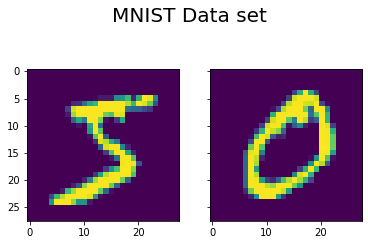

In [120]:
# Verify data was correctly read in by plotting a few images
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('MNIST Data set', fontsize=20)
ax1.imshow(nist_data[0, :, :])
ax2.imshow(nist_data[1, :, :])

In [121]:
# Parameter(s) of Levy-Lindenbaum 
B  = 50                               # Batch number 
k  = 10                               # Number of columns to preserve
ff = 1.0                              # Forget factor 
h  = np.shape(nist_data)[0]           # Image height
w  = np.shape(nist_data)[1]           # Image width
num_imgs = np.shape(nist_data)[2]     # Total number of images

# Find value of third 
N = round(np.shape(nist_data)[0]/B)

# Reshape data as to not harm images
nist_data_batched = nist_data.swapaxes(0, 1)
nist_data_batched = nist_data_batched.swapaxes(1, 2)
nist_data_batched = nist_data_batched.reshape(h*w, -1)
nist_data_batched = nist_data_batched.reshape(-1, B, N)

# Run Levy-Lindenbaum streaming algorithmn
k_col, singular_vals = levy_lindenbaum(nist_data_batched, ff, k)




Plot both singuar values of this result

Text(0, 0.5, 'Singular Values')

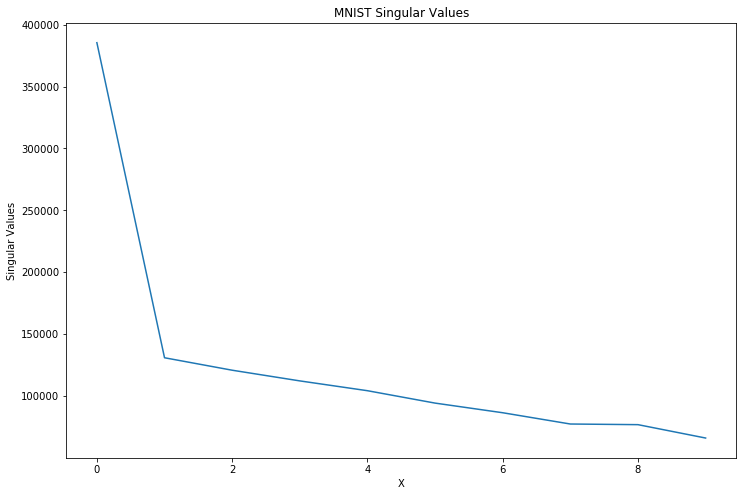

In [122]:
# Plot singular values
plt.figure(figsize=(12, 8))
plt.plot(singular_vals)
plt.title('MNIST Singular Values')
plt.xlabel('X')
plt.ylabel("Singular Values")

Plot abslute values of the mode this result

Text(0, 0.5, 'Modes')

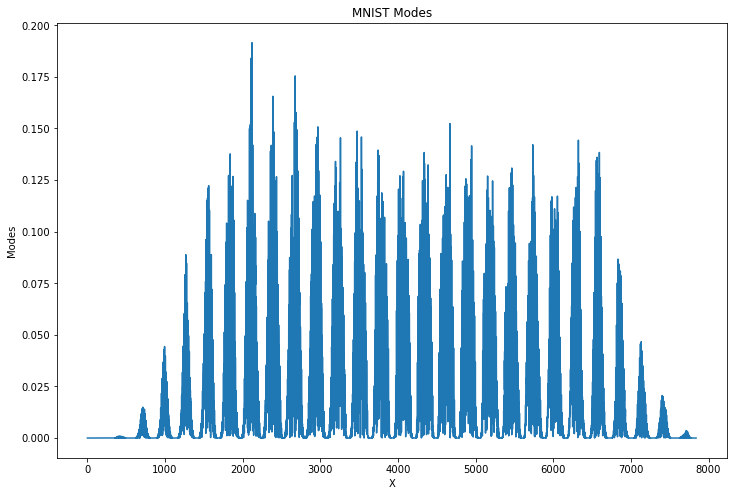

In [123]:
# Take absolute values 
k_col = np.absolute(k_col)

# Vectorize 
k_col = k_col.reshape(-1)

# Plot singular values
plt.figure(figsize=(12, 8))
plt.plot(k_col)
plt.title('MNIST Modes')
plt.xlabel('X')
plt.ylabel("Modes")

## Problem 2 ## 

Here, will asses the average run times of this algorithmn for varying batch sizes. Additionally, will visulaize the evolution of the first three-singular vectors for each batch as a video. For these test, will assume a forget factor of 1.0.

In [124]:
# Batch size of all 10 trials
batch_sizes = np.array([5, 10, 20, 30, 50, 60, 80, 100])

# Parameter(s) of Levy-Lindenbaum 
k          = 10   # Number of columns to preserve
ff         = 1.0  # Forget factor 
num_trials = 10    # Number of trials
h = 28
w = 28

# Value of third dimensions  
N = (np.shape(nist_data)[0]/batch_sizes).astype(int) 

# Reshape data as to not harm images
nist_data_pre = nist_data.swapaxes(0, 1)
nist_data_pre = nist_data_pre.swapaxes(1, 2)
nist_data_pre = nist_data_pre.reshape(h*w, -1)

# Allocate space to storage run times for each case
run_time = np.zeros((np.shape(batch_sizes)[0], 1))

# Allocate space for first three singular vectors
first_three_singular_vec = np.zeros((28*28, 3, np.shape(batch_sizes)[0]))

# Run Levy-lindenbaum/np.linalg for each batch size and record run time
for i in np.arange(0, np.shape(batch_sizes)[0]):
    print("Starting trial for Batch Size: ", batch_sizes[i], "\n")
    
    # Reshape to current batch_size
    nist_data_batched = nist_data_pre.reshape(-1, batch_sizes[i], N[i])
    
    for j in np.arange(0, num_trials):        
        # Start timer for trial
        start_time = time.time()  
    
        # Start Levy Lindenbaum
        k_col, singular_vals = levy_lindenbaum(nist_data_batched, ff, k)
    
        # End time and store 
        run_time[i] += time.time() - start_time
        
    run_time[i] = run_time[i]/num_trials
    print("Average Time:", run_time[i] ,"\n")
    
    # Store first singular values
    first_three_singular_vec[:, :, i] = k_col[:, :3]    

Starting trial for Batch Size:  5 

Average Time: [9.73430588] 

Starting trial for Batch Size:  10 

Average Time: [10.07632308] 

Starting trial for Batch Size:  20 

Average Time: [12.07030704] 

Starting trial for Batch Size:  30 

Average Time: [15.39677689] 

Starting trial for Batch Size:  50 

Average Time: [22.53380563] 

Starting trial for Batch Size:  60 

Average Time: [24.75314438] 

Starting trial for Batch Size:  80 

Average Time: [28.13612123] 

Starting trial for Batch Size:  100 

Average Time: [36.26333969] 



Plot average run-time for each of the 10 trials 

Text(0, 0.5, 'Average Run Time')

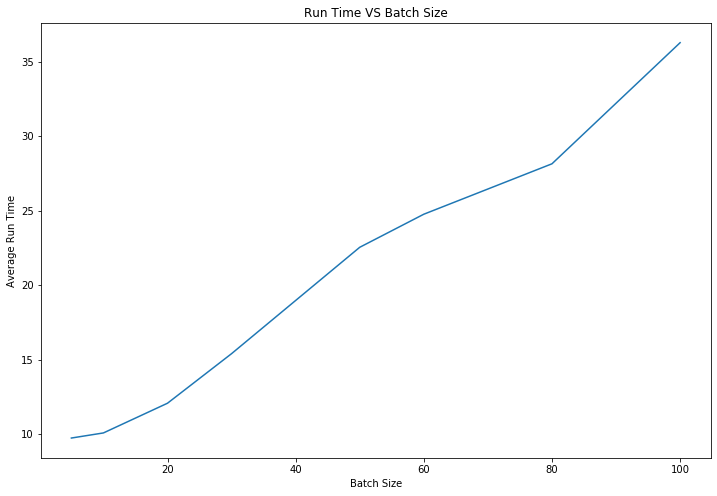

In [125]:
# Plot singular values
plt.figure(figsize=(12, 8))
plt.plot(batch_sizes, run_time)
plt.title('Run Time VS Batch Size')
plt.xlabel('Batch Size')
plt.ylabel("Average Run Time")

Create gifs of the evolution of the first three singular vectors. SAVING IN GIFS DIRECTORY

In [129]:

# Path to Gifs
gif_1 = os.path.abspath('').replace('scripts', 'gifs') +  '\\sig1.png'
gif_2 = os.path.abspath('').replace('scripts', 'gifs') +  '\\sig2.png'
gif_3 = os.path.abspath('').replace('scripts', 'gifs') +  '\\sig3.png'

# First set
img1 = first_three_singular_vec[:, 0, :]
img1 = img1.reshape((28, 28, 8))
img1 = img1.swapaxes(0, 2)

# First set
img2 = first_three_singular_vec[:, 1, :]
img2 = img2.reshape((28, 28, 8))
img2 = img2.swapaxes(0, 2)

# First set
img3 = first_three_singular_vec[:, 2, :]
img3 = img3.reshape((28, 28, 8))
img3 = img3.swapaxes(0, 2)

# Make gifs
gif_maker(img1, gif_1)
gif_maker(img2, gif_2)
gif_maker(img3, gif_3)


C:\ProgramData\Anaconda3\envs\purdue_v3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

Here, will qualtitatively assess the singular vector computed with our algorithmn to those of np.linalg.svd for different values of the forget factor. 

In [130]:
# Parameter(s) of Levy-Lindenbaum 
B  = 50                           # Batch number 
k  = 10                           # Number of columns to preserve
ff = [0.2, 0.5, 1.0]              # Forget factor 

# Find value of third 
N = round(np.shape(nist_data)[0]/B)

# Reshape data as to not harm images
nist_data_batched = nist_data.swapaxes(0, 1)
nist_data_batched = nist_data_batched.swapaxes(1, 2)
nist_data_batched = nist_data_batched.reshape(h*w, -1)
nist_data_batched = nist_data_batched.reshape(-1, B, N)

# Storage for singular vectors for each forget factor
singular_vec_ff = np.zeros((np.shape(nist_data)[1]**2, len(ff)))

# Perform SVD decomposition
U, S, V = np.linalg.svd(nist_data_batched)

# Perform levy-lindebaum for each ff factor 
for i in np.arange(0, len(ff)):
    print("Performing ff trial: ", i, "\n")
    
    # Start Levy Lindenbaum
    k_col, singular_vals = levy_lindenbaum(nist_data_batched, ff[i], k)
        
    # Store singular vectors
    singular_vec_ff[:, i] = k_col[:, 0]


Performing ff trial:  0 

Performing ff trial:  1 

Performing ff trial:  2 



Plot qualitative results for np.linalg versus streaming SVD

(784, 3)


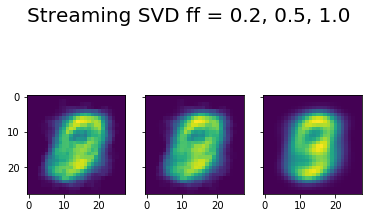

In [131]:

print(np.shape(singular_vec_ff))

img1 = singular_vec_ff[:, 0].reshape(28, 28)
img2 = singular_vec_ff[:, 1].reshape(28, 28)
img3 = singular_vec_ff[:, 2].reshape(28, 28)

# Plot Streaming 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True)
fig.suptitle('Streaming SVD ff = 0.2, 0.5, 1.0', fontsize=20)
ax1.imshow(img1)
ax2.imshow(img2)
ax3.imshow(img3)

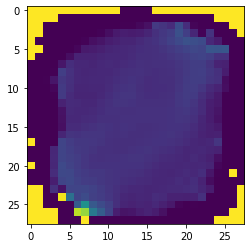

In [134]:

nist_data_mean_sub = nist_data_batched

# Perform SVD decomposition
U, S, V = np.linalg.svd(nist_data_mean_sub)

img_svd = np.abs(U[:, 0, 0])
img_svd = img_svd.reshape(28, 28)

imgplot = plt.imshow(img_svd)
plt.show()

As we can see, as the value of the forget factor is increased we reach a solution which approximated the SVD result! 